In [16]:
import sys
import joblib
import logging
import warnings
import requests
import multiprocessing
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from zero_shot_learner import extend_df_with_cos_sim
from preprocessor import NewsPreprocessor
from contractions import contractions_dict
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger()
logger.disabled = True

In [8]:
def progressbar(iter, prefix="", size=60, file=sys.stdout):
    # Reference from https://stackoverflow.com/questions/3160699/python-progress-bar
    count = len(iter)
    def show(t):
        x = int(size*t/count)
        # file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), int(100*t/count), 100))
        file.write("{}[{}{}] {}%\r".format(prefix, "#"*x, "."*(size-x), int(100*t/count)))
        file.flush()
    show(0)
    for i, item in enumerate(iter):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [9]:
def load_stock(ticker_name, start_date="2012-01-01"):
    ticker = yf.Ticker(ticker_name)
    hist = ticker.history(period="max", start=start_date)
    hist.index = hist.index.set_names(['date'])
    hist = hist.reset_index(drop=False, inplace=False)
    hist["date"] = pd.to_datetime(hist["date"], utc=True)
    hist['date'] = hist['date'].apply(lambda x: x.date())
    hist.sort_values(by='date', inplace=True)
    hist.reset_index(drop=True, inplace=True)
    hist["ticker"] = ticker_name
    hist["label"] = hist["Close"].diff(periods=1)
    hist.dropna(inplace=True)
    hist["label"] = hist["label"].map(lambda x: 1 if float(x) >= 0 else 0)
    return hist

def load_news(df, labels, sort_by, k):
    """
    :param file_name: str
    :param labels: list of str (for zero-shot learner)
    :param sort_by: str (str in labels)
    :param k: int (top k news)
    :return: pandas dataframe
    """
    df.drop_duplicates(subset="title", inplace=True)
    preprocessor = NewsPreprocessor(contractions_dict=contractions_dict)
    df["clean_title"] = df["title"].apply(lambda x: preprocessor.ultimate_clean(x))
    df = extend_df_with_cos_sim(df=df, col="clean_title", labels=labels, sort_by=sort_by)
    df = transform_df(df=df, sort_by=sort_by, k=k)
    df.reset_index(drop=True, inplace=True)
    return df

def transform_df(df, by, sort_by, k=10):
    """
    Transform dataframe into another dataframe with top k news using zero-shot learner.
    :param df: pandas dataframe
    :param sort_by: str
    :param k: int
    :return: pandas dataframe
    """
    # Group tweets by date and aggregate into a list
    df_temp = df.copy()
    df_temp["date"] = pd.to_datetime(df_temp["date"], utc=True)
    df_temp['date'] = df_temp['date'].apply(lambda x: x.date())
    df_temp = df_temp.sort_values(['date', sort_by], ascending=False).groupby('date').head(100)
    df_temp = df_temp.groupby("date")[by].agg(list)
    df_temp = df_temp.reset_index(drop=False, inplace=False)
    df_temp.columns = ["date", "agg_news"]

    # Create top k tweet columns
    new_cols = ["Top {} News".format(i + 1) for i in range(k)]
    df_temp = df_temp.assign(**dict.fromkeys(new_cols, np.NaN))

    # Update every columns
    print("Start transforming dataframe...")
    for index, row in df_temp.iterrows():
        try:
            i = 1
            for news in row["agg_news"]:
                column = "Top {} News".format(i)
                df_temp.loc[index, column] = news
                i += 1
                if i > k:
                    break
        except:
            pass
    df = df_temp.drop("agg_news", axis=1)
    print("Done!")

    return df

In [4]:
# from jupyterthemes import jtplot

# # currently installed theme will be used to
# # set plot style if no arguments provided
# jtplot.style(theme="oceans16")

In [10]:
def merge_function(df, ticker, return_dict):
    news = df[df["ticker"] == str(ticker)]
    news = load_news(news, labels=["stock"], sort_by="stock", k=5)
    stock = load_stock(str(ticker), start_date="2012-01-01")
    news_and_stock = pd.merge(news, stock, on=["date"])
    news_and_stock.set_index('date', inplace=True)
    return_dict[ticker] = news_and_stock

In [11]:
TRAIN_START_DATE = "2012-01-01"
TRAIN_END_DATE = "2015-12-31"
VALID_START_DATE = "2016-01-01"
VALID_END_DATE = "2016-12-31"
TEST_START_DATE = "2017-01-01"
TEST_END_DATE = "2020-07-01"

train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

df_merge = joblib.load("../data/sp500_top100_v4.bin")

for ticker in tqdm(df_merge["ticker"].unique()):
    news = df_merge[df_merge["ticker"] == str(ticker)]
    news = transform_df(df=news, by="ps_content_filter", sort_by="sim", k=10)
    stock = load_stock(str(ticker), start_date="2012-01-01")
    news_and_stock = pd.merge(news, stock, on=["date"])
    news_and_stock.set_index('date', inplace=True)
    
    train_temp = news_and_stock.loc[pd.to_datetime(TRAIN_START_DATE).date():pd.to_datetime(TRAIN_END_DATE).date()]
    valid_temp = news_and_stock.loc[pd.to_datetime(VALID_START_DATE).date():pd.to_datetime(VALID_END_DATE).date()]
    test_temp = news_and_stock.loc[pd.to_datetime(TEST_START_DATE).date():pd.to_datetime(TEST_END_DATE).date()]
    
    train = pd.concat([train, train_temp], axis=0)
    valid = pd.concat([valid, valid_temp], axis=0)
    test = pd.concat([test, test_temp], axis=0)

Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transforming dataframe...
Done!
Start transf

In [12]:
joblib.dump(train, "../data/train_top10_v3.bin", compress=5)
joblib.dump(valid, "../data/valid_top10_v3.bin", compress=5)
joblib.dump(test, "../data/test_top10_v3.bin", compress=5)

['../data/test_top10_v3.bin']

In [13]:
train

,Top 1 News,Top 2 News,Top 3 News,Top 4 News,Top 5 News,Top 6 News,Top 7 News,Top 8 News,Top 9 News,Top 10 News,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,label
date,,,,,,,,,,,,,,,,,,,
2012-01-04,(Reuters) - Apple Inc has appointed Adobe Syst...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.71,51.28,50.62,51.13,65005500.0,0.0,0.0,AAPL,1
2012-01-05,Apple is also embroiled in acrimonious lawsuit...,The statement said the two companies would als...,The statement said the two companies would als...,Apple is also embroiled in acrimonious lawsuit...,NaN,NaN,NaN,NaN,NaN,NaN,51.32,51.76,51.04,51.70,67817400.0,0.0,0.0,AAPL,1
2012-01-09,The group behind the lawsuit has been lobbying...,Las Vegas (Reuters) - Apple Inc will again dom...,"Based on an August 24, 2011 closing price, tha...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.62,52.90,52.11,52.16,98506100.0,0.0,0.0,AAPL,0
2012-01-10,"Kodak also sued Taiwan’s HTC Corp, alleging vi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.67,52.68,52.13,52.34,64549100.0,0.0,0.0,AAPL,1
2012-01-11,One of the biggest gripes about CES is that Ap...,One of the biggest gripes about CES is that Ap...,(Reuters) - Apple Inc (AAPL.O) sent out media ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.27,52.29,51.86,52.26,53771200.0,0.0,0.0,AAPL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-24,The Rating Outlook is Stable.The ratings upgra...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.69,50.60,49.69,50.21,1004200.0,0.0,0.0,FIS,1
2014-01-29,"Jan 29 (Reuters) - ServiceNow Inc, a software ...",empty content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.19,58.22,56.44,57.60,1998900.0,0.0,0.0,NOW,0
2014-04-24,"Revenue rose 62 percent to $139.1 million, bea...",The company also reported better-than-expected...,The company also reported better-than-expected...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.70,54.70,45.07,49.88,10440700.0,0.0,0.0,NOW,0


In [14]:
valid

,Top 1 News,Top 2 News,Top 3 News,Top 4 News,Top 5 News,Top 6 News,Top 7 News,Top 8 News,Top 9 News,Top 10 News,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,label
date,,,,,,,,,,,,,,,,,,,
2016-01-04,Shares of Apple are down about 23 percent from...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.40,97.97,94.83,97.95,67649400.0,0.0,0.0,AAPL,1
2016-01-05,"Other companies affected include Sony Corp, wh...",Other companies affected include image sensor ...,"Reuters provides trusted business, financial, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.32,98.41,95.22,95.49,55791000.0,0.0,0.0,AAPL,0
2016-01-06,"On New Year’s day alone, customers spent more ...","In afternoon trading, the stock briefly traded...","On New Year’s day alone, customers spent more ...",(Reuters) - Apple Inc (AAPL.O) shares dropped ...,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",empty content,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Earlier on Wednesday, Japanese daily Nikkei, c...",93.49,95.18,92.85,93.63,68457400.0,0.0,0.0,AAPL,0
2016-01-07,The tech giant’s plans for Emotient were not i...,"Reuters provides trusted business, financial, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.75,93.10,89.66,89.67,81094400.0,0.0,0.0,AAPL,0
2016-01-08,(Reuters) - Apple Inc has registered domain na...,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",NaN,NaN,NaN,NaN,NaN,NaN,91.63,92.15,89.96,90.15,70798000.0,0.0,0.0,AAPL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-14,empty content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.08,63.50,61.90,63.00,3443600.0,0.0,0.0,NOW,0
2016-04-21,empty content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.77,76.84,73.21,74.27,8395500.0,0.0,0.0,NOW,1
2016-06-01,empty content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.38,73.50,71.06,73.17,1889700.0,0.0,0.0,NOW,1


In [15]:
test

,Top 1 News,Top 2 News,Top 3 News,Top 4 News,Top 5 News,Top 6 News,Top 7 News,Top 8 News,Top 9 News,Top 10 News,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,label
date,,,,,,,,,,,,,,,,,,,
2017-01-04,Jan 4 (Reuters) - Apple Inc has removed the Ne...,"""We believe their new fund will speed the deve...",“We believe their new fund will speed the deve...,“We believe their new fund will speed the deve...,NaN,NaN,NaN,NaN,NaN,NaN,110.11,110.73,110.01,110.27,21118100.0,0.0,0.0,AAPL,0
2017-01-05,"Apple wants to open its own stores in India, b...",SEOUL (Reuters) - Apple Inc (AAPL.O) said it w...,Billings from popular subscription-based apps ...,Billings from popular subscription-based apps ...,"Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...","Reuters provides trusted business, financial, ...",NaN,NaN,110.17,111.07,110.07,110.83,22193600.0,0.0,0.0,AAPL,1
2017-01-06,empty content,Reporting by Alastair Sharp; Editing by Paul S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.99,112.30,110.70,112.07,31751900.0,0.0,0.0,AAPL,1
2017-01-10,(Reuters) - Electric carmaker Tesla Motors Inc...,BEIJING (Reuters) - China’s largest mobile soc...,BEIJING (Reuters) - China’s largest mobile soc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.88,113.46,112.44,113.21,24462100.0,0.0,0.0,AAPL,1
2017-01-12,A group of iPhone users sued saying the Cuper...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.01,113.39,112.35,113.34,27086200.0,0.0,0.0,AAPL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12,"Luka Mucic, finance chief, said SAP will reduc...",empty content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.29,253.49,249.20,252.53,1888800.0,0.0,0.0,NOW,1
2019-11-18,Reporting by Tassilo HummelAll quotes delayed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.00,268.45,257.30,266.31,3082300.0,0.0,0.0,NOW,1
2019-12-16,NEW YORK (Reuters) - It sounds counterintuitiv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.33,281.80,274.11,281.79,2082500.0,0.0,0.0,NOW,1


In [19]:
def check_nan(df):
    plt.figure(figsize=(16, 8))
    sns.heatmap(df.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
    plt.title("Missing Values Heatmap")
    plt.show()

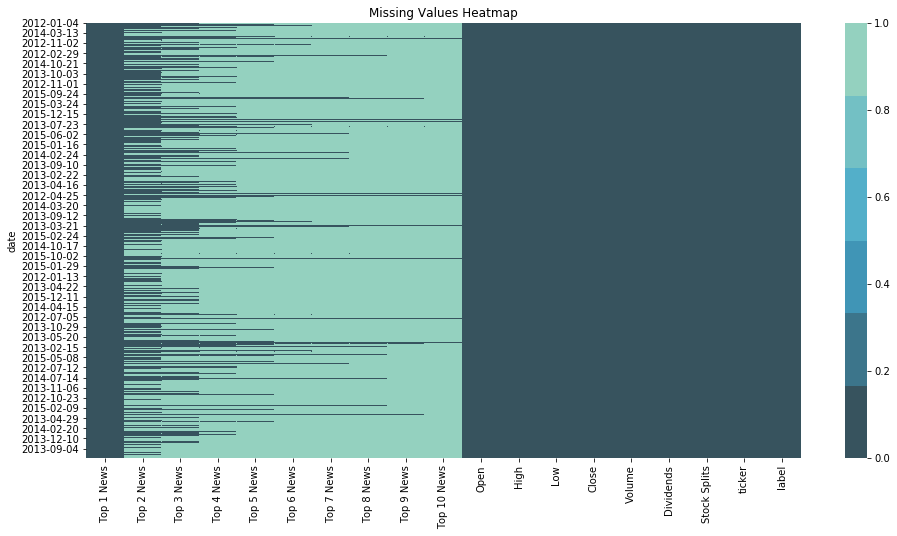

In [23]:
check_nan(train)

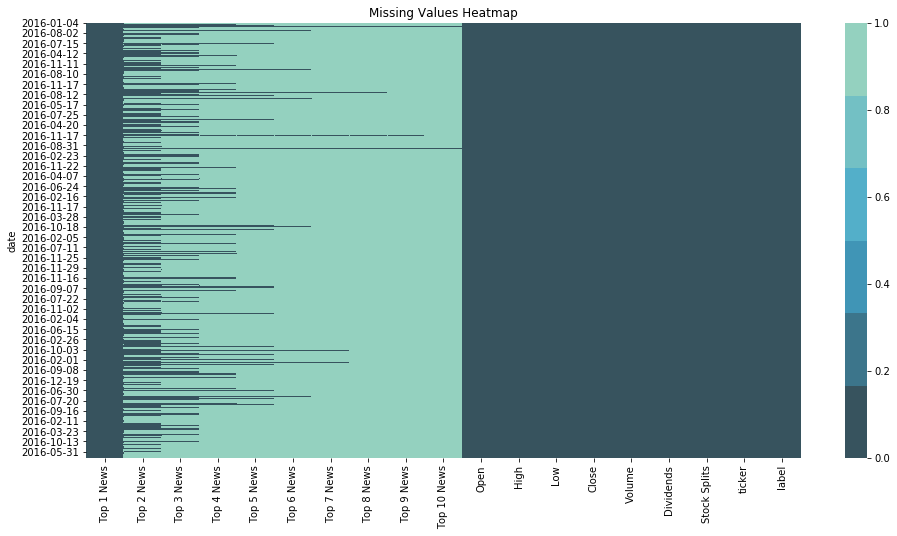

In [24]:
check_nan(valid)

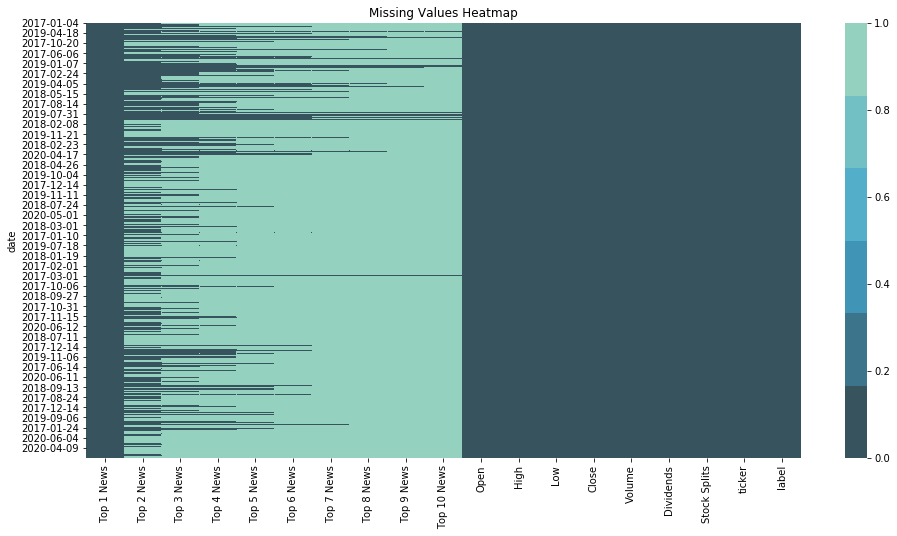

In [25]:
check_nan(test)